In [1]:
# importing Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider

In [2]:
def threeSAT_oracle(circuit, f_in, f_out, aux, n, expression):
    num_clauses = len(expression)
    for k, clause in enumerate(expression):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if 2 literals are true
        for literal_1 in clause:
                if literal_1 > 0:
                    l1 = literal_1
                else:
                    l1 = -literal_1
                for literal_2 in clause:
                    if literal_1 >= literal_2:
                        continue
                    if literal_2 > 0:
                        l2 = literal_2
                    else:
                        l2 = -literal_2
                    circuit.ccx(f_in[l1-1], f_in[l2-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    else:
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        for i in range(2, num_clauses-1):
            circuit.ccx(aux[i], aux[num_clauses+i-2], aux[num_clauses+i-1])
        circuit.ccx(aux[num_clauses-1], aux[2*num_clauses-3], f_out[0])
        for i in range(num_clauses-2, 1, -1):
            circuit.ccx(aux[i], aux[num_clauses+i-2], aux[num_clauses+i-1])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])

    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for k, clause in enumerate(expression):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        for literal_1 in clause:
                if literal_1 > 0:
                    l1 = literal_1
                else:
                    l1 = -literal_1
                for literal_2 in clause:
                    if literal_1 >= literal_2:
                        continue
                    if literal_2 > 0:
                        l2 = literal_2
                    else:
                        l2 = -literal_2
                    circuit.ccx(f_in[l1-1], f_in[l2-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])

In [3]:
def exactly1_threeSAT_oracle(circuit, f_in, f_out, aux, n, expression):
    num_clauses = len(expression)
    for k, clause in enumerate(expression):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    if num_clauses == 1:
        circuit.cx(aux[0], f_out[0])
    elif num_clauses == 2:
        circuit.ccx(aux[0], aux[1], f_out[0])
    else:
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        for i in range(2, num_clauses-1):
            circuit.ccx(aux[i], aux[num_clauses+i-2], aux[num_clauses+i-1])
        circuit.ccx(aux[num_clauses-1], aux[2*num_clauses-3], f_out[0])
        for i in range(num_clauses-2, 1, -1):
            circuit.ccx(aux[i], aux[num_clauses+i-2], aux[num_clauses+i-1])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    for k, clause in enumerate(expression):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])

In [4]:
def n_controlled_Z(qc, controls, target, aux):
    n = len(controls)
    qc.h(target)
    if (n == 1):
        qc.cx(controls[0], target)
    elif (n == 2):
        qc.ccx(controls[0], controls[1], target)
    else:
        qc.ccx(controls[0], controls[1], aux[0])
        for i in range(2, n-1):
            qc.ccx(controls[i], aux[i-2], aux[i-1])
        qc.ccx(controls[n-1], aux[n-3], target)
        for i in range(n-2, 1, -1):
            qc.ccx(controls[i], aux[i-2], aux[i-1])
        qc.ccx(controls[0], controls[1], aux[0])
    qc.h(target)
    

def reflect_around_psi(qc, qr1, aux, n=3):
    for j in range(n):
        qc.h(qr1[j])
        qc.x(qr1[j])
    n_controlled_Z(qc, qr1[:-1], qr1[-1], aux)
    for j in range(n):
        qc.x(qr1[j])
        qc.h(qr1[j])

In [5]:
def input_state(qc, qr1, qr2, n=3):
    for j in range(n):
        qc.h(qr1[j])
    qc.x(qr2)
    qc.h(qr2)
    qc.barrier()

In [6]:
# Make a quantum program for the n-bit Grover search.
n = 4
expression = [[1, 2, 3], [-1, 3, 4], [1,2,-4], [-2,3,-4], [-2,-3,4]]

# n = 3
# expression = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

num_run = 4

grovers=[]

for num_grover in range(1,num_run+1):
    var = QuantumRegister(n)
    res = QuantumRegister(1)
    aux = QuantumRegister(2*len(expression)-2)
    ans = ClassicalRegister(n)

    grover = QuantumCircuit()
    grover.add_register(var)
    grover.add_register(res)
    grover.add_register(aux)
    grover.add_register(ans)

    input_state(grover, var, res, n)

    for _ in range(num_grover):
        threeSAT_oracle(grover, var, res, aux, n, expression)
        # exactly1_threeSAT_oracle(grover, var, res, aux, n, expression)
        grover.barrier()
        reflect_around_psi(grover, var, aux, n)
        grover.barrier()

    for j in range(n):
        grover.measure(var[j], ans[j])
    grovers.append(grover)

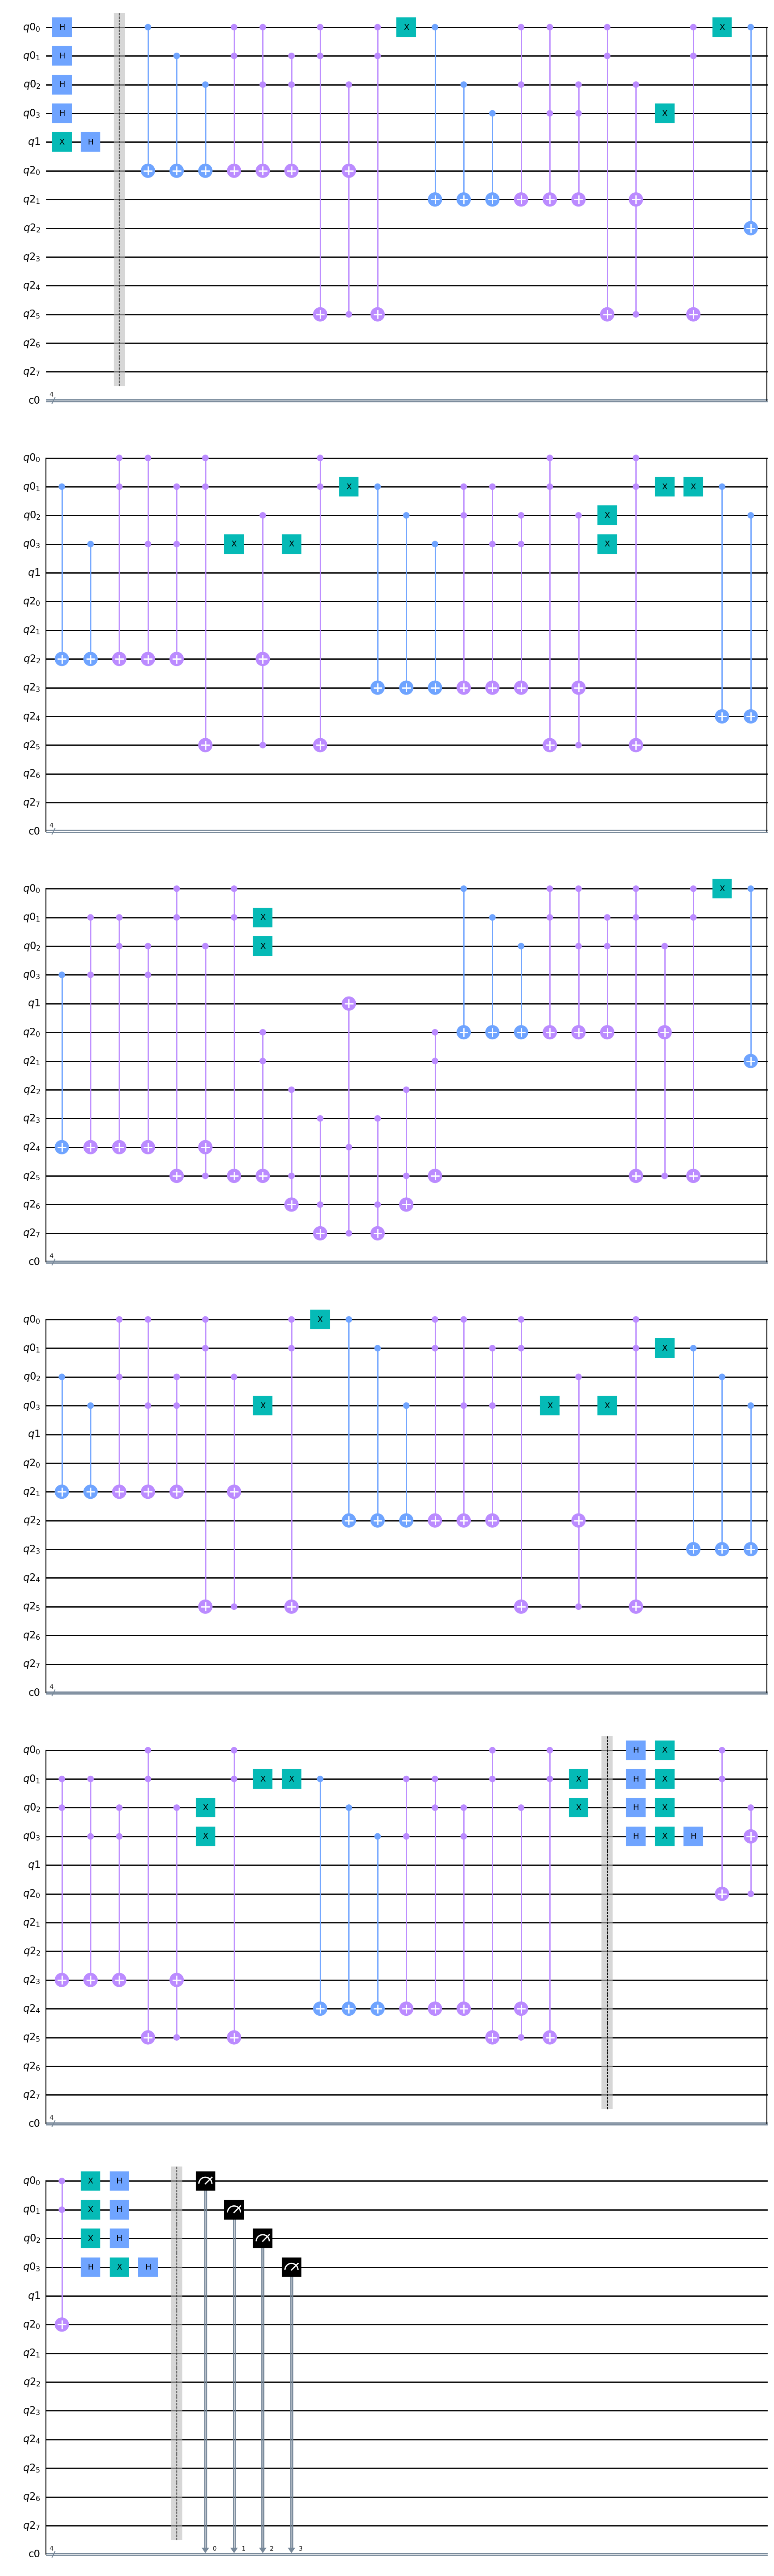

In [7]:
grovers[0].draw(output='mpl')

In [8]:
TOKEN = '0bfde51be0ca119033457d3de0402238f21ab3410bf6ec73318dbb4758822d67ea2521639a26c6605efd108a9d06a7bfc1496866b38273e624f35f42a56a1cad'

provider = IBMProvider(token=TOKEN)

# display current supported backends
# print(provider.backends())

# get IBM's simulator backend
backend = provider.get_backend('ibmq_qasm_simulator')

In [9]:
results=[]
histos=[]

for grover in grovers:
    # Execute circuit
    job = execute(grover, backend=backend)
    result = job.result()
    counts = result.get_counts(grover)

    results.append(result)
    histos.append(plot_histogram(counts))

In [10]:
len(histos)

4

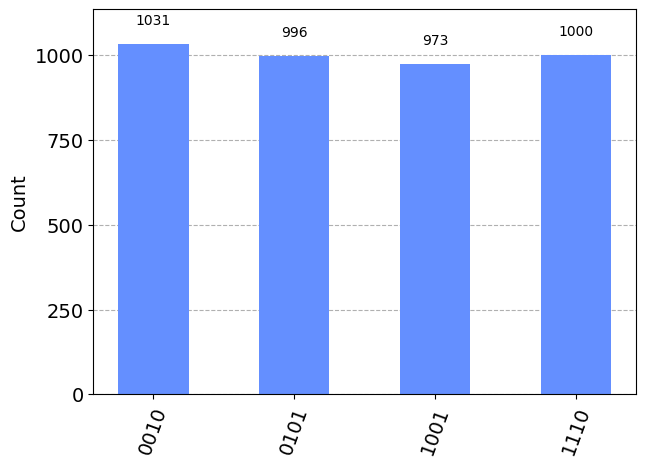

In [11]:
histos[0]

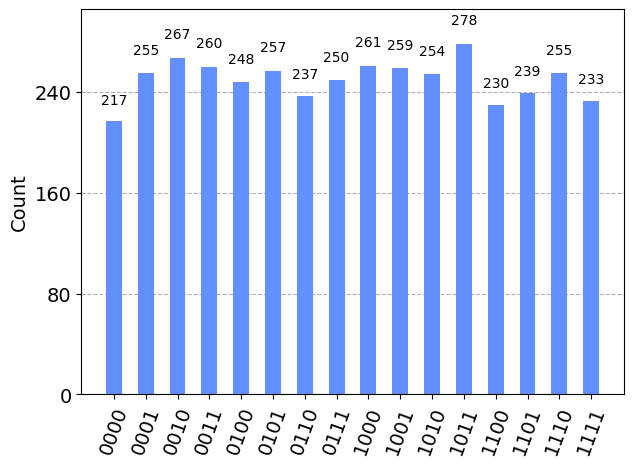

In [12]:
histos[1]

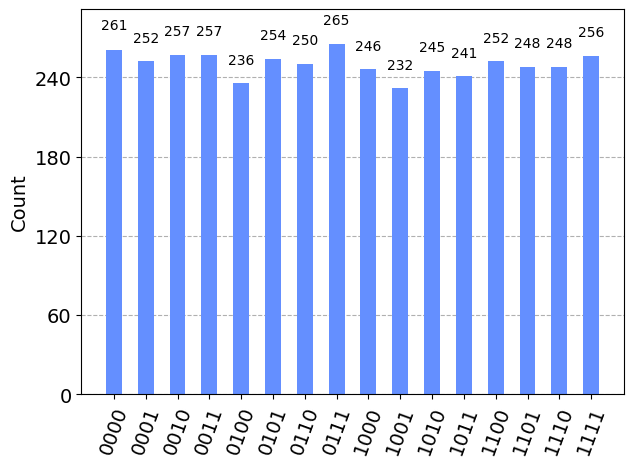

In [13]:
histos[2]

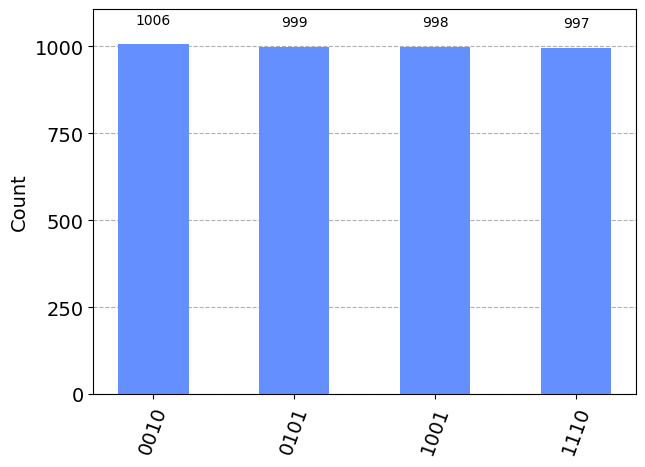

In [14]:
histos[3]

In [15]:
histos[4]

IndexError: list index out of range